Data preparation


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# ---------------------------------------
# STEP 1: LOAD & PREPARE DATA
# ---------------------------------------
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv')

target = 'converted'

# Identify features
categorical = ['industry', 'employment_status', 'lead_source', 'location']
numerical = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

# Fill missing values
df[categorical] = df[categorical].fillna('NA')
df[numerical] = df[numerical].fillna(0.0)

# Split into train/val/test (60/20/20)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1, stratify=df[target])
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1, stratify=df_full_train[target])

y_train = df_train[target].astype(int)

Question1

In [54]:
# ---------------------------------------
# STEP 2: ROC AUC for each numerical feature
# ---------------------------------------
from sklearn.metrics import roc_auc_score

auc_scores = {}

for col in numerical:
    scores = df_train[col]
    auc = roc_auc_score(y_train, scores)
    
    # If AUC < 0.5, invert the variable
    if auc < 0.5:
        auc = roc_auc_score(y_train, -scores)
    
    auc_scores[col] = auc
    print(f"{col:25s} -> AUC: {auc:.3f}")

# ---------------------------------------
# STEP 3: Identify best feature
# ---------------------------------------
best_feature = max(auc_scores, key=auc_scores.get)
print(f"\nBest numerical feature by AUC: {best_feature} ({auc_scores[best_feature]:.3f})")


lead_score                -> AUC: 0.618
number_of_courses_viewed  -> AUC: 0.752
interaction_count         -> AUC: 0.706
annual_income             -> AUC: 0.567

Best numerical feature by AUC: number_of_courses_viewed (0.752)


0.9

Question2

In [59]:
# Identify categorical and numerical columns
categorical = df_train.select_dtypes(include='object').columns.tolist()
numerical = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']
features = categorical + numerical

# Fill missing values
for col in categorical:
    df_train[col] = df_train[col].fillna('NA')
    df_val[col] = df_val[col].fillna('NA')

for col in numerical:
    df_train[col] = pd.to_numeric(df_train[col], errors='coerce').fillna(0.0)
    df_val[col] = pd.to_numeric(df_val[col], errors='coerce').fillna(0.0)

# Convert to dict for DictVectorizer
train_dict = df_train[features].to_dict(orient='records')
val_dict = df_val[features].to_dict(orient='records')

# One-hot encoding
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

# Train logistic regression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, df_train['converted'].values)

# Predict and compute AUC
y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(df_val['converted'].values, y_pred)
round(auc, 3)


0.9

Question3

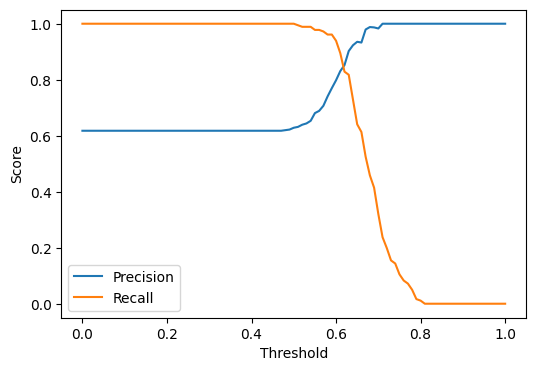

0.62

In [61]:
import numpy as np
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

y_true = df_val['converted'].values

for t in thresholds:
    y_pred_label = (y_pred >= t).astype(int)
    precisions.append(precision_score(y_true, y_pred_label, zero_division=1))
    recalls.append(recall_score(y_true, y_pred_label))

# Plot
plt.figure(figsize=(6,4))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

# Find threshold where precision and recall are closest
diff = np.abs(np.array(precisions) - np.array(recalls))
best_threshold = thresholds[np.argmin(diff)]
best_threshold


Question4

In [62]:
import numpy as np
from sklearn.metrics import precision_score, recall_score

thresholds = np.arange(0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_label = (y_pred >= t).astype(int)  # y_pred from your model
    P = precision_score(y_val, y_pred_label, zero_division=0)
    R = recall_score(y_val, y_pred_label, zero_division=0)
    
    if P + R == 0:
        f1 = 0
    else:
        f1 = 2 * P * R / (P + R)
    
    f1_scores.append(f1)

f1_scores = np.array(f1_scores)
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

print("Max F1:", f1_scores[best_idx])
print("Threshold for max F1:", best_threshold)


Max F1: 0.8629441624365481
Threshold for max F1: 0.6


Question5

In [63]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
import numpy as np

def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    X = dv.transform(dicts)
    return model.predict_proba(X)[:, 1]

# 5-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kf.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train['converted'].values  # replace 'converted' with your target column
    y_val = df_val['converted'].values
    
    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

scores = np.array(scores)
print("AUC scores per fold:", scores)
print("Mean AUC:", scores.mean())
print("Std of AUC:", scores.std())


AUC scores per fold: [0.80125302 0.83748443 0.86160714 0.77801587 0.8060946 ]
Mean AUC: 0.8168910142722202
Std of AUC: 0.029312137624452266


Question6

In [64]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
import numpy as np

C_values = [0.000001, 0.001, 1]
kf = KFold(n_splits=5, shuffle=True, random_state=1)

results = []

for C in C_values:
    scores = []
    for train_idx, val_idx in kf.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        
        y_train = df_train['converted'].values  # replace with your target
        y_val = df_val['converted'].values
        
        dicts = df_train[categorical + numerical].to_dict(orient='records')
        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(dicts)
        
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)
        
        X_val = dv.transform(df_val[categorical + numerical].to_dict(orient='records'))
        y_pred = model.predict_proba(X_val)[:, 1]
        scores.append(roc_auc_score(y_val, y_pred))
    
    mean_score = round(np.mean(scores), 3)
    std_score = round(np.std(scores), 3)
    results.append((C, mean_score, std_score))

for C, mean_score, std_score in results:
    print(f"C={C}, mean AUC={mean_score}, std={std_score}")


C=1e-06, mean AUC=0.561, std=0.035
C=0.001, mean AUC=0.86, std=0.026
C=1, mean AUC=0.817, std=0.029
